# **Detection of ACL injuries using AlexNet**  - 2019


*   Dataset used is [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/)




In [1]:
# Libraries
from matplotlib import pyplot as plt
from matplotlib.animation import PillowWriter
from torch.utils import data
from sklearn import metrics
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as T
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.animation as animation
import imgaug.augmenters as iaa
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import cv2
import os
from   google.colab import drive

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Constants
MRNET_PATH           = '/content/drive/MyDrive/MRNet-v1.0/'
TRAIN_PATH           = '/content/drive/MyDrive/MRNet-v1.0/train/'
VAL_PATH             = '/content/drive/MyDrive/MRNet-v1.0/valid/'
BATCH_SIZE = 1
RANDOM_STATE = 1234
EPOCHS = 50
PATIENT = 10
LOSS_IMPROVE = 1e-04
MAX_PIXEL_VALUE = 255

In [4]:
# Specify seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

In [5]:
# Load Stanford MRI Dataset
train_df_abnormal = pd.read_csv(MRNET_PATH + 'train-abnormal.csv', header=None)
train_df_acl = pd.read_csv(MRNET_PATH + 'train-acl.csv', header=None)
train_df_meniscus = pd.read_csv(MRNET_PATH + 'train-meniscus.csv', header=None)

valid_df_abnormal = pd.read_csv(MRNET_PATH + 'valid-abnormal.csv', header=None)
valid_df_acl = pd.read_csv(MRNET_PATH + 'valid-acl.csv', header=None)
valid_df_meniscus = pd.read_csv(MRNET_PATH + 'valid-meniscus.csv', header=None)

train_df = pd.concat([train_df_abnormal, train_df_acl[1], train_df_meniscus[1]], axis=1).drop_duplicates()
valid_df = pd.concat([valid_df_abnormal, valid_df_acl[1], valid_df_meniscus[1]], axis=1).drop_duplicates()
train_df.columns = ['Image', 'Abnormal', 'ACL', 'Meniscus']
valid_df.columns = ['Image', 'Abnormal', 'ACL', 'Meniscus']

pd.concat([train_df, valid_df], axis=0).reset_index(drop=True).to_csv(MRNET_PATH + '/knee_metadata.csv')

In [6]:
# Define MRDataset class
class MRDataset(data.Dataset):
    def __init__(self, transform=False, train=True, train_index_limit=1130):
        super().__init__()
        self.transform = transform
        self.train = train
        self.records = pd.read_csv(MRNET_PATH + '/knee_metadata.csv')
        self.train_index_limit = train_index_limit
        self.planes = ['axial', 'sagittal', 'coronal']
        self.image_path = {}

        if self.train:
            for plane in self.planes:
                self.image_path[plane] = TRAIN_PATH + '/{0}/'.format(plane)
            self.records = self.records.iloc[0:self.train_index_limit, :]
        else:
            for plane in self.planes:
                self.image_path[plane] = VAL_PATH + '/{0}/'.format(plane)
            self.records = self.records.iloc[self.train_index_limit:, :]

        self.records['Image'] = self.records['Image'].map(lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = {}
        for plane in self.planes:
            self.paths[plane] = [self.image_path[plane] + filename + '.npy' for filename in self.records['Image'].tolist()]

        self.labels = self.records[['Abnormal', 'ACL', 'Meniscus']].values
        weights_ = []
        for disease in list(range(0, 3)):
            pos = sum(self.labels[:, disease])
            neg = len(self.labels[:, disease]) - pos
            weights_.append(neg / pos)
        self.weights = torch.FloatTensor(weights_)

    def __len__(self):
        return len(self.records)

    def __getitem__(self, index):
        transform = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(
                translate_percent={"x": (-0.11, 0.11), "y": (-0.11, 0.11)},
                scale={"x": (1, 1.2), "y": (1, 1.2)},
                rotate=(-10, 10)
            )
        ])

        img_raw = {}
        for plane in self.planes:
            img_raw[plane] = np.load(self.paths[plane][index])
            img_raw[plane] = (img_raw[plane]) / MAX_PIXEL_VALUE
            if self.transform:
                img_raw_transformed = transform(images=img_raw[plane])
                img_raw[plane] = np.stack((img_raw_transformed,) * 3, axis=1)
            else:
                img_raw[plane] = np.stack((img_raw[plane],) * 3, axis=1)

            img_raw[plane] = torch.FloatTensor(img_raw[plane])

        label = self.labels[index]
        label = torch.FloatTensor(label)
        return [img_raw[plane] for plane in self.planes], label


In [7]:
# Get dataset
train_dataset = MRDataset(transform=True)
val_dataset = MRDataset(train=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2)

In [8]:
# Build Conv2D model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.axial = models.alexnet(pretrained=True, progress=False).features
        self.sagittal = models.alexnet(pretrained=True, progress=False).features
        self.coronal = models.alexnet(pretrained=True, progress=False).features
        self.features_conv_axial = self.axial[:12]
        self.features_conv_sagittal = self.sagittal[:12]
        self.features_conv_coronal = self.coronal[:12]
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.avg_pool_axial = nn.AdaptiveAvgPool2d(1)
        self.avg_pool_sagittal = nn.AdaptiveAvgPool2d(1)
        self.avg_pool_coronal = nn.AdaptiveAvgPool2d(1)
        self.gradients_axial = None
        self.gradients_sagittal = None
        self.gradients_coronal = None
        self.fc = nn.Sequential(nn.Linear(in_features=3 * 256, out_features=3))

    def activations_hook_axial(self, grad):
        self.gradients_axial = grad

    def activations_hook_sagittal(self, grad):
        self.gradients_sagittal = grad

    def activations_hook_coronal(self, grad):
        self.gradients_coronal = grad

    def forward(self, x):
        images = [torch.squeeze(img, dim=0) for img in x]
        image1 = self.features_conv_axial(images[0])
        image2 = self.features_conv_sagittal(images[1])
        image3 = self.features_conv_coronal(images[2])
        h_axial = image1.register_hook(self.activations_hook_axial)
        h_sagittal = image2.register_hook(self.activations_hook_sagittal)
        h_coronal = image3.register_hook(self.activations_hook_coronal)
        image1 = self.max_pool(image1)
        image2 = self.max_pool(image2)
        image3 = self.max_pool(image3)
        image1 = self.avg_pool_axial(image1).view(image1.size(0), -1)
        image2 = self.avg_pool_sagittal(image2).view(image2.size(0), -1)
        image3 = self.avg_pool_coronal(image3).view(image3.size(0), -1)
        image1 = torch.max(image1, dim=0, keepdim=True)[0]
        image2 = torch.max(image2, dim=0, keepdim=True)[0]
        image3 = torch.max(image3, dim=0, keepdim=True)[0]
        output = torch.cat([image1, image2, image3], dim=1)
        output = self.fc(output)
        return output

    def get_activations_gradient(self):
        return [self.gradients_axial, self.gradients_sagittal, self.gradients_coronal]

    def get_activations(self, x):
        images = [torch.squeeze(img, dim=0) for img in x]
        return [self.features_conv_axial(images[0]), self.features_conv_sagittal(images[1]), self.features_conv_coronal(images[2])]

# Initialize model
model = CNNModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


In [9]:
# Define error criterion and optimize functions
train_criterion = nn.BCEWithLogitsLoss(pos_weight=train_dataset.weights)
val_criterion = nn.BCEWithLogitsLoss(pos_weight=val_dataset.weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.3, threshold=1e-4, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
# Get Sensitivity-Specificity metrics
def get_sensitivity_specificity(y_true, y_pred):
    abnormal_true = list(map(lambda x: x[0], y_true))
    abnormal_pred = list(map(lambda x: x[0], y_pred))
    ACL_true = list(map(lambda x: x[1], y_true))
    ACL_pred = list(map(lambda x: x[1], y_pred))
    meniscus_true = list(map(lambda x: x[2], y_true))
    meniscus_pred = list(map(lambda x: x[2], y_pred))
    tn_ab, fp_ab, fn_ab, tp_ab = metrics.confusion_matrix(abnormal_true, abnormal_pred).ravel()
    tn_acl, fp_acl, fn_acl, tp_acl = metrics.confusion_matrix(ACL_true, ACL_pred).ravel()
    tn_men, fp_men, fn_men, tp_men = metrics.confusion_matrix(meniscus_true, meniscus_pred).ravel()
    sensitivity = [round(tp_ab / (tp_ab + fn_ab), 4), round(tp_acl / (tp_acl + fn_acl), 4), round(tp_men / (tp_men + fn_men), 4)]
    specificity = [round(tn_ab / (tn_ab + fp_ab), 4), round(tn_acl / (tn_acl + fp_acl), 4), round(tn_men / (tn_men + fp_men), 4)]
    return sensitivity, specificity

In [11]:
# Define train function
def train(train_data, model, criterion):
    print('Training...')
    model.train()
    counter = 0
    correct = 0
    train_running_loss = 0.0
    total = 0.0
    prediction_list = []
    label_list = []
    for input_data, label in tqdm(train_data):
        if torch.cuda.is_available():
            input_data, label = [data.cuda() for data in input_data], label.cuda()
        counter += 1
        optimizer.zero_grad()
        outputs = model(input_data)
        outputs_sig = torch.sigmoid(outputs)
        predicted = torch.round(outputs_sig)
        prediction_list.append(list(predicted.cpu().detach().numpy())[0])
        label_list.append(list(label.cpu().detach().numpy())[0])
        total += label.size(1)
        correct += (np.array(predicted.cpu().detach().numpy())[0] == np.array(label.cpu().detach().numpy())[0]).sum().item()
        loss = criterion(outputs.cpu(), label.cpu())
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_accuracy = correct / total
    train_loss = train_running_loss / counter
    train_auc = metrics.roc_auc_score(label_list, prediction_list, average='macro', multi_class='ovr')
    return train_loss, train_accuracy, train_auc, prediction_list

In [12]:
# Define val function
def val(val_data, model, criterion):
    print('Validating...')
    model.eval()
    counter = 0
    correct = 0
    val_running_loss = 0.0
    total = 0.0
    prediction_list = []
    label_list = []
    for input_data, label in tqdm(val_data):
        if torch.cuda.is_available():
            input_data, label = [data.cuda() for data in input_data], label.cuda()
        counter += 1
        outputs = model(input_data)
        outputs_sig = torch.sigmoid(outputs)
        predicted = torch.round(outputs_sig)
        prediction_list.append(list(predicted.cpu().detach().numpy())[0])
        label_list.append(list(label.cpu().detach().numpy())[0])
        total += label.size(1)
        correct += (np.array(predicted.cpu().detach().numpy())[0] == np.array(label.cpu().detach().numpy())[0]).sum().item()
        loss = criterion(outputs.cpu(), label.cpu())
        val_running_loss += loss.item()
    val_accuracy = correct / total
    val_loss = val_running_loss / counter
    val_auc = metrics.roc_auc_score(label_list, prediction_list, average='macro', multi_class='ovr')
    sensitivity, specificity = get_sensitivity_specificity(label_list, prediction_list)
    return val_loss, val_accuracy, val_auc, prediction_list, sensitivity, specificity


In [14]:
# Early Stopping Parameters
best_val_loss = float('inf')
patient_counter = 0
early_stopping_patience = PATIENT

# Metrics Storage
train_loss = []
train_accuracy = []
train_auc = []
valid_loss = []
valid_accuracy = []
valid_auc = []

if torch.cuda.is_available():
    model = model.cuda()

print("Starting Training...")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_auc, train_predictions = train(train_loader, model, train_criterion)
    val_epoch_loss, val_epoch_accuracy, val_epoch_auc, val_predictions, val_sensitivity, val_specificity = val(val_loader, model, val_criterion)
    scheduler.step(val_epoch_loss)

    # Check for improvement
    if val_epoch_loss < best_val_loss - LOSS_IMPROVE:
        print(f"Val loss improved from {best_val_loss:.4f} to {val_epoch_loss:.4f}. Saving model...")
        best_val_loss = val_epoch_loss
        patient_counter = 0
        torch.save(model.state_dict(), f'{MRNET_PATH}/models/best_model.pth')
    else:
        print("Val loss did not improve")
        patient_counter += 1
        if patient_counter >= early_stopping_patience:
            print("Early stopping triggered. Training halted.")
            break

    # Append metrics
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_auc.append(train_epoch_auc)
    valid_loss.append(val_epoch_loss)
    valid_accuracy.append(val_epoch_accuracy)
    valid_auc.append(val_epoch_auc)

    # Log metrics
    print(f"Train Acc: {train_epoch_accuracy:.4f} | Val Acc: {val_epoch_accuracy:.4f}")
    print(f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")
    print(f"Train AUC: {train_epoch_auc:.4f} | Val AUC: {val_epoch_auc:.4f}")
    print("Val-Sensitivity. Abnormal: {:.4f}, ACL: {:.4f}, Meniscus: {:.4f}".format(*val_sensitivity))
    print("Val-Specificity. Abnormal: {:.4f}, ACL: {:.4f}, Meniscus: {:.4f}".format(*val_specificity))
    print("-" * 80)

Starting Training...
Epoch 1 of 50
Training...


100%|██████████| 1130/1130 [15:48<00:00,  1.19it/s]


Validating...


100%|██████████| 120/120 [02:39<00:00,  1.33s/it]


Val loss improved from inf to 0.5460. Saving model...
Train Acc: 0.6729 | Val Acc: 0.6944
Train Loss: 0.6931 | Val Loss: 0.5460
Train AUC: 0.6569 | Val AUC: 0.6547
Val-Sensitivity. Abnormal: 0.9368, ACL: 0.4444, Meniscus: 0.9615
Val-Specificity. Abnormal: 0.4400, ACL: 0.9394, Meniscus: 0.2059
--------------------------------------------------------------------------------
Epoch 2 of 50
Training...


100%|██████████| 1130/1130 [06:38<00:00,  2.84it/s]


Validating...


100%|██████████| 120/120 [00:24<00:00,  4.85it/s]


Val loss improved from 0.5460 to 0.4912. Saving model...
Train Acc: 0.7218 | Val Acc: 0.7611
Train Loss: 0.6428 | Val Loss: 0.4912
Train AUC: 0.7128 | Val AUC: 0.7455
Val-Sensitivity. Abnormal: 0.8632, ACL: 0.5000, Meniscus: 0.6346
Val-Specificity. Abnormal: 0.8000, ACL: 0.9545, Meniscus: 0.7206
--------------------------------------------------------------------------------
Epoch 3 of 50
Training...


100%|██████████| 1130/1130 [06:44<00:00,  2.80it/s]


Validating...


100%|██████████| 120/120 [00:27<00:00,  4.29it/s]


Val loss improved from 0.4912 to 0.4596. Saving model...
Train Acc: 0.7463 | Val Acc: 0.7583
Train Loss: 0.5995 | Val Loss: 0.4596
Train AUC: 0.7401 | Val AUC: 0.7606
Val-Sensitivity. Abnormal: 0.8105, ACL: 0.6296, Meniscus: 0.6731
Val-Specificity. Abnormal: 0.8800, ACL: 0.8939, Meniscus: 0.6765
--------------------------------------------------------------------------------
Epoch 4 of 50
Training...


100%|██████████| 1130/1130 [06:39<00:00,  2.83it/s]


Validating...


100%|██████████| 120/120 [00:27<00:00,  4.37it/s]


Val loss did not improve
Train Acc: 0.7507 | Val Acc: 0.7667
Train Loss: 0.5830 | Val Loss: 0.4639
Train AUC: 0.7544 | Val AUC: 0.7455
Val-Sensitivity. Abnormal: 0.9053, ACL: 0.5185, Meniscus: 0.6731
Val-Specificity. Abnormal: 0.7600, ACL: 0.9394, Meniscus: 0.6765
--------------------------------------------------------------------------------
Epoch 5 of 50
Training...


100%|██████████| 1130/1130 [06:40<00:00,  2.82it/s]


Validating...


100%|██████████| 120/120 [00:23<00:00,  5.09it/s]


Val loss did not improve
Train Acc: 0.7575 | Val Acc: 0.7500
Train Loss: 0.5680 | Val Loss: 0.4685
Train AUC: 0.7635 | Val AUC: 0.7152
Val-Sensitivity. Abnormal: 0.9579, ACL: 0.7593, Meniscus: 0.9231
Val-Specificity. Abnormal: 0.4800, ACL: 0.8030, Meniscus: 0.3676
--------------------------------------------------------------------------------
Epoch 6 of 50
Training...


100%|██████████| 1130/1130 [06:41<00:00,  2.81it/s]


Validating...


100%|██████████| 120/120 [00:24<00:00,  4.88it/s]


Val loss improved from 0.4596 to 0.4514. Saving model...
Train Acc: 0.7699 | Val Acc: 0.7750
Train Loss: 0.5600 | Val Loss: 0.4514
Train AUC: 0.7761 | Val AUC: 0.7340
Val-Sensitivity. Abnormal: 0.9579, ACL: 0.7778, Meniscus: 0.8269
Val-Specificity. Abnormal: 0.4800, ACL: 0.7879, Meniscus: 0.5735
--------------------------------------------------------------------------------
Epoch 7 of 50
Training...


100%|██████████| 1130/1130 [06:50<00:00,  2.75it/s]


Validating...


100%|██████████| 120/120 [00:24<00:00,  4.93it/s]


Val loss did not improve
Train Acc: 0.7776 | Val Acc: 0.7611
Train Loss: 0.5394 | Val Loss: 0.4633
Train AUC: 0.7829 | Val AUC: 0.7349
Val-Sensitivity. Abnormal: 0.8842, ACL: 0.5556, Meniscus: 0.4615
Val-Specificity. Abnormal: 0.7600, ACL: 0.9394, Meniscus: 0.8088
--------------------------------------------------------------------------------
Epoch 8 of 50
Training...


100%|██████████| 1130/1130 [06:50<00:00,  2.76it/s]


Validating...


100%|██████████| 120/120 [00:26<00:00,  4.60it/s]


Val loss did not improve
Train Acc: 0.7737 | Val Acc: 0.7889
Train Loss: 0.5241 | Val Loss: 0.4612
Train AUC: 0.7832 | Val AUC: 0.7452
Val-Sensitivity. Abnormal: 0.9579, ACL: 0.6852, Meniscus: 0.8654
Val-Specificity. Abnormal: 0.4800, ACL: 0.9091, Meniscus: 0.5735
--------------------------------------------------------------------------------
Epoch 9 of 50
Training...


100%|██████████| 1130/1130 [06:54<00:00,  2.73it/s]


Validating...


100%|██████████| 120/120 [00:24<00:00,  4.84it/s]


Val loss improved from 0.4514 to 0.4302. Saving model...
Train Acc: 0.7817 | Val Acc: 0.7861
Train Loss: 0.5145 | Val Loss: 0.4302
Train AUC: 0.7881 | Val AUC: 0.7625
Val-Sensitivity. Abnormal: 0.9263, ACL: 0.7407, Meniscus: 0.8462
Val-Specificity. Abnormal: 0.6400, ACL: 0.8333, Meniscus: 0.5882
--------------------------------------------------------------------------------
Epoch 10 of 50
Training...


100%|██████████| 1130/1130 [06:43<00:00,  2.80it/s]


Validating...


100%|██████████| 120/120 [00:26<00:00,  4.52it/s]


Val loss did not improve
Train Acc: 0.7912 | Val Acc: 0.7389
Train Loss: 0.4960 | Val Loss: 0.4937
Train AUC: 0.8014 | Val AUC: 0.7067
Val-Sensitivity. Abnormal: 0.9368, ACL: 0.7037, Meniscus: 0.9615
Val-Specificity. Abnormal: 0.4800, ACL: 0.8788, Meniscus: 0.2794
--------------------------------------------------------------------------------
Epoch 11 of 50
Training...


100%|██████████| 1130/1130 [06:38<00:00,  2.83it/s]


Validating...


100%|██████████| 120/120 [00:25<00:00,  4.78it/s]


Val loss did not improve
Train Acc: 0.7885 | Val Acc: 0.7917
Train Loss: 0.4907 | Val Loss: 0.4441
Train AUC: 0.7975 | Val AUC: 0.7454
Val-Sensitivity. Abnormal: 0.9474, ACL: 0.6852, Meniscus: 0.7885
Val-Specificity. Abnormal: 0.4800, ACL: 0.9242, Meniscus: 0.6471
--------------------------------------------------------------------------------
Epoch 12 of 50
Training...


100%|██████████| 1130/1130 [06:40<00:00,  2.82it/s]


Validating...


100%|██████████| 120/120 [00:26<00:00,  4.54it/s]


Val loss improved from 0.4302 to 0.4227. Saving model...
Train Acc: 0.7962 | Val Acc: 0.7944
Train Loss: 0.4791 | Val Loss: 0.4227
Train AUC: 0.8036 | Val AUC: 0.7840
Val-Sensitivity. Abnormal: 0.9263, ACL: 0.7593, Meniscus: 0.8654
Val-Specificity. Abnormal: 0.7600, ACL: 0.8636, Meniscus: 0.5294
--------------------------------------------------------------------------------
Epoch 13 of 50
Training...


100%|██████████| 1130/1130 [06:35<00:00,  2.86it/s]


Validating...


100%|██████████| 120/120 [00:25<00:00,  4.72it/s]


Val loss improved from 0.4227 to 0.4202. Saving model...
Train Acc: 0.7997 | Val Acc: 0.8056
Train Loss: 0.4738 | Val Loss: 0.4202
Train AUC: 0.8140 | Val AUC: 0.7809
Val-Sensitivity. Abnormal: 0.9263, ACL: 0.7222, Meniscus: 0.6731
Val-Specificity. Abnormal: 0.7200, ACL: 0.8788, Meniscus: 0.7647
--------------------------------------------------------------------------------
Epoch 14 of 50
Training...


100%|██████████| 1130/1130 [06:33<00:00,  2.87it/s]


Validating...


100%|██████████| 120/120 [00:25<00:00,  4.68it/s]


Val loss improved from 0.4202 to 0.4118. Saving model...
Train Acc: 0.8147 | Val Acc: 0.8000
Train Loss: 0.4580 | Val Loss: 0.4118
Train AUC: 0.8266 | Val AUC: 0.7822
Val-Sensitivity. Abnormal: 0.9263, ACL: 0.7407, Meniscus: 0.7115
Val-Specificity. Abnormal: 0.7600, ACL: 0.8636, Meniscus: 0.6912
--------------------------------------------------------------------------------
Epoch 15 of 50
Training...


100%|██████████| 1130/1130 [06:36<00:00,  2.85it/s]


Validating...


100%|██████████| 120/120 [00:25<00:00,  4.66it/s]


Val loss did not improve
Train Acc: 0.8121 | Val Acc: 0.8083
Train Loss: 0.4547 | Val Loss: 0.4133
Train AUC: 0.8211 | Val AUC: 0.7768
Val-Sensitivity. Abnormal: 0.9368, ACL: 0.8333, Meniscus: 0.7500
Val-Specificity. Abnormal: 0.6000, ACL: 0.8788, Meniscus: 0.6618
--------------------------------------------------------------------------------
Epoch 16 of 50
Training...


100%|██████████| 1130/1130 [06:40<00:00,  2.82it/s]


Validating...


100%|██████████| 120/120 [00:26<00:00,  4.58it/s]


Val loss did not improve
Train Acc: 0.8192 | Val Acc: 0.7806
Train Loss: 0.4386 | Val Loss: 0.4651
Train AUC: 0.8293 | Val AUC: 0.7313
Val-Sensitivity. Abnormal: 0.9579, ACL: 0.5556, Meniscus: 0.8077
Val-Specificity. Abnormal: 0.4800, ACL: 0.9545, Meniscus: 0.6324
--------------------------------------------------------------------------------
Epoch 17 of 50
Training...


100%|██████████| 1130/1130 [06:45<00:00,  2.79it/s]


Validating...


100%|██████████| 120/120 [00:26<00:00,  4.47it/s]


Val loss did not improve
Train Acc: 0.8221 | Val Acc: 0.7806
Train Loss: 0.4353 | Val Loss: 0.4949
Train AUC: 0.8290 | Val AUC: 0.7428
Val-Sensitivity. Abnormal: 0.9895, ACL: 0.9259, Meniscus: 0.8654
Val-Specificity. Abnormal: 0.4800, ACL: 0.6667, Meniscus: 0.5294
--------------------------------------------------------------------------------
Epoch 18 of 50
Training...


100%|██████████| 1130/1130 [06:25<00:00,  2.93it/s]


Validating...


100%|██████████| 120/120 [00:24<00:00,  4.87it/s]


Val loss did not improve
Train Acc: 0.8301 | Val Acc: 0.7750
Train Loss: 0.4198 | Val Loss: 0.5132
Train AUC: 0.8408 | Val AUC: 0.7306
Val-Sensitivity. Abnormal: 0.9895, ACL: 0.6296, Meniscus: 0.9038
Val-Specificity. Abnormal: 0.4800, ACL: 0.9394, Meniscus: 0.4412
--------------------------------------------------------------------------------
Epoch 19 of 50
Training...


100%|██████████| 1130/1130 [06:50<00:00,  2.75it/s]


Validating...


100%|██████████| 120/120 [00:24<00:00,  4.85it/s]


Val loss did not improve
Train Acc: 0.8460 | Val Acc: 0.7750
Train Loss: 0.3774 | Val Loss: 0.4354
Train AUC: 0.8528 | Val AUC: 0.7413
Val-Sensitivity. Abnormal: 0.9368, ACL: 0.6852, Meniscus: 0.8269
Val-Specificity. Abnormal: 0.5600, ACL: 0.9242, Meniscus: 0.5147
--------------------------------------------------------------------------------
Epoch 20 of 50
Training...


100%|██████████| 1130/1130 [06:46<00:00,  2.78it/s]


Validating...


100%|██████████| 120/120 [00:28<00:00,  4.27it/s]


Val loss did not improve
Train Acc: 0.8484 | Val Acc: 0.7722
Train Loss: 0.3754 | Val Loss: 0.4489
Train AUC: 0.8606 | Val AUC: 0.7278
Val-Sensitivity. Abnormal: 0.9474, ACL: 0.6481, Meniscus: 0.8077
Val-Specificity. Abnormal: 0.4800, ACL: 0.9394, Meniscus: 0.5441
--------------------------------------------------------------------------------
Epoch 21 of 50
Training...


100%|██████████| 1130/1130 [06:49<00:00,  2.76it/s]


Validating...


100%|██████████| 120/120 [00:25<00:00,  4.79it/s]


Val loss did not improve
Train Acc: 0.8519 | Val Acc: 0.7833
Train Loss: 0.3649 | Val Loss: 0.4355
Train AUC: 0.8621 | Val AUC: 0.7415
Val-Sensitivity. Abnormal: 0.9474, ACL: 0.6667, Meniscus: 0.7885
Val-Specificity. Abnormal: 0.5200, ACL: 0.9091, Meniscus: 0.6176
--------------------------------------------------------------------------------
Epoch 22 of 50
Training...


100%|██████████| 1130/1130 [06:41<00:00,  2.81it/s]


Validating...


100%|██████████| 120/120 [00:27<00:00,  4.38it/s]


Val loss did not improve
Train Acc: 0.8593 | Val Acc: 0.7889
Train Loss: 0.3633 | Val Loss: 0.4397
Train AUC: 0.8734 | Val AUC: 0.7402
Val-Sensitivity. Abnormal: 0.9579, ACL: 0.6481, Meniscus: 0.7692
Val-Specificity. Abnormal: 0.4800, ACL: 0.9242, Meniscus: 0.6618
--------------------------------------------------------------------------------
Epoch 23 of 50
Training...


100%|██████████| 1130/1130 [06:46<00:00,  2.78it/s]


Validating...


100%|██████████| 120/120 [00:26<00:00,  4.58it/s]


Val loss did not improve
Train Acc: 0.8619 | Val Acc: 0.7861
Train Loss: 0.3442 | Val Loss: 0.4407
Train AUC: 0.8730 | Val AUC: 0.7438
Val-Sensitivity. Abnormal: 0.9579, ACL: 0.7593, Meniscus: 0.8269
Val-Specificity. Abnormal: 0.4800, ACL: 0.9091, Meniscus: 0.5294
--------------------------------------------------------------------------------
Epoch 24 of 50
Training...


100%|██████████| 1130/1130 [06:40<00:00,  2.82it/s]


Validating...


100%|██████████| 120/120 [00:24<00:00,  4.82it/s]

Val loss did not improve
Early stopping triggered. Training halted.


In [15]:
# Final Results Table
final_results = {
    "Metric": ["Train Accuracy", "Val Accuracy", "Train AUC", "Val AUC", "Train Loss", "Val Loss"],
    "Results": [
        train_accuracy[-1],
        valid_accuracy[-1],
        train_auc[-1],
        valid_auc[-1],
        train_loss[-1],
        valid_loss[-1]
    ]
}
final_df = pd.DataFrame(final_results)

print("\nFinal Results:")
print(final_df.to_string(index=False))



Final Results:
        Metric  Results
Train Accuracy 0.861947
  Val Accuracy 0.786111
     Train AUC 0.873005
       Val AUC 0.743763
    Train Loss 0.344239
      Val Loss 0.440723


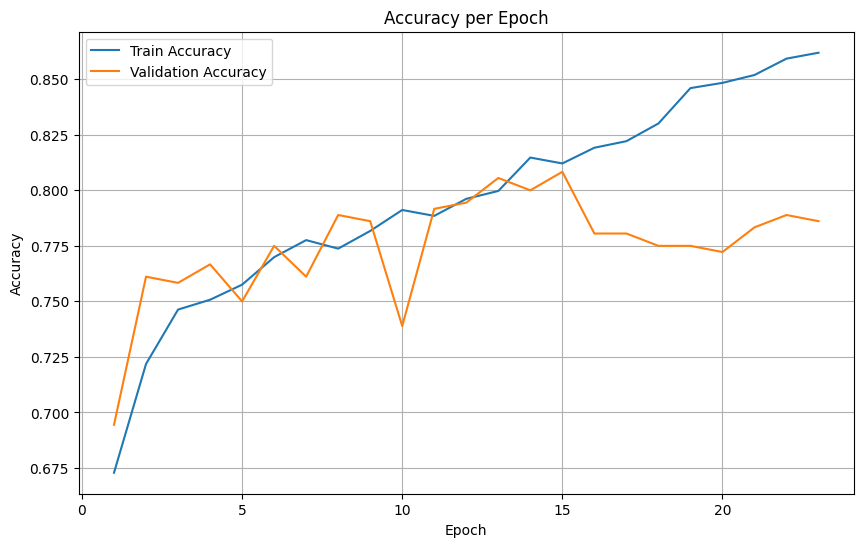

In [16]:
# Accuracy Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(valid_accuracy) + 1), valid_accuracy, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.savefig(f'{MRNET_PATH}/plots/accuracy_plot.png')
plt.show()

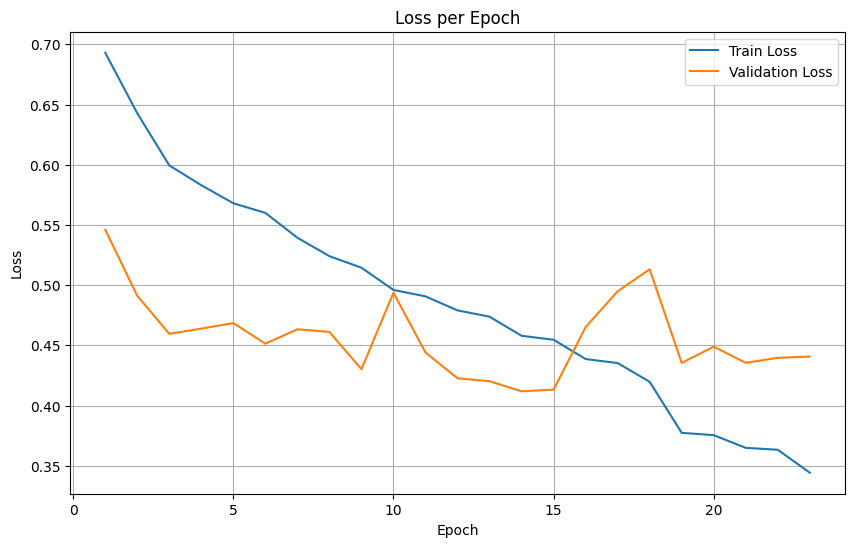

In [17]:
# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(valid_loss) + 1), valid_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.savefig(f'{MRNET_PATH}/plots/loss_plot.png')
plt.show()

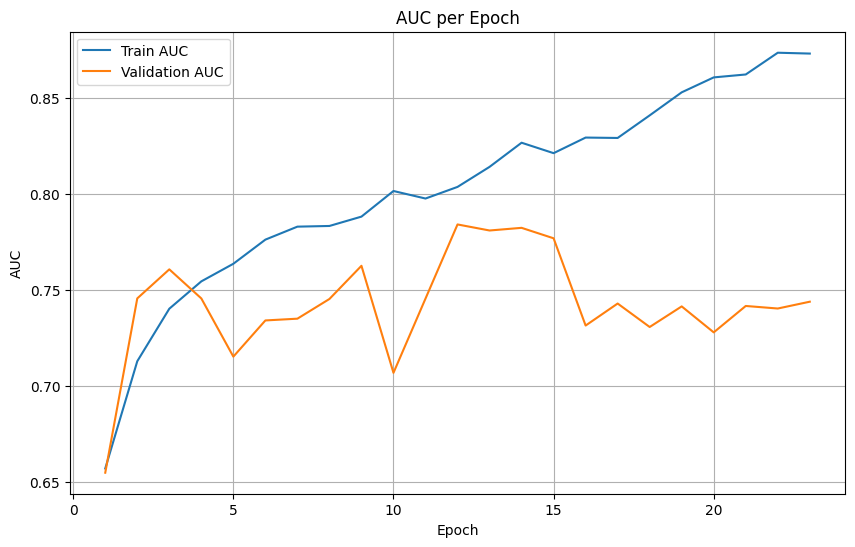

In [18]:
# AUC Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_auc) + 1), train_auc, label='Train AUC')
plt.plot(range(1, len(valid_auc) + 1), valid_auc, label='Validation AUC')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC per Epoch")
plt.legend()
plt.grid(True)
plt.savefig(f'{MRNET_PATH}/plots/auc_plot.png')
plt.show()